# Objective

Following [variance_map_ps.ipynb](variance_map_ps.ipynb), now I try to implement the method given in Appendix A of Planck CO Revisited (Ghosh, S., et al.: A&A, 688, A54).

# Imports and Parameters

In [1]:
from pathlib import Path

import numpy as np
import healpy as hp

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from handle_data import get_map_dtype, get_planck_obs_data, get_planck_noise_data

In [2]:
DATA_ROOT = "/data/jim/CMB_Data/"
ASSETS_DIRECTORY = f"{DATA_ROOT}/Assets/Planck/"
PLANCK_NOISE_DIR = f"{DATA_ROOT}/Planck_Noise/"

DETECTOR = 100
RANDOM_SEED = 42
PLANCK_SIM_NUM = 0
BOXCAR_LENGTH = 2
SMOOTH_INITIAL = True

NSIDE_512 = 512
NSIDE_2048 = 2048

In [3]:
def get_lmax_for_nside(nside):
    """Helper function: Max ell for a given nside; to be considered a parameter"""
    return 3 * nside - 1

# Display PS Helpers

In [4]:
def plot_ps(ps,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            white_noise_expected=None):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    plt.plot(ps)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    if white_noise_expected is not None:
        plt.axhline(y=white_noise_expected, color='black', linestyle='--')
        plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
                 color='black',
                 horizontalalignment='right', verticalalignment='bottom')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.show()

In [5]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            styles=None,
            labels=None,
            white_noise_expected=None):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    for i, ps in enumerate(ps_s):
        if styles is None:
            style = None
            linewidth = None
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        label = None if labels is None else labels[i]
        plt.plot(ps, label=label, linestyle=style, linewidth=linewidth)
    if white_noise_expected is not None:
        plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
        plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
                 color='black',
                 horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
def make_map_hist(some_map, noise_level, title=None):
    plt.hist(some_map, bins=100, histtype='step')
    plt.axvline(noise_level, color='black', linestyle='--', linewidth=1)
    plt.axvline(-noise_level, color='black', linestyle='--', linewidth=1)
    plt.text(x=-noise_level, y=175000, s=f"$-\\sigma$", color='black', 
            rotation=90,
            verticalalignment='center', horizontalalignment='right')
    offset = transforms.ScaledTranslation(2/72, 0, plt.gcf().dpi_scale_trans)
    plt.text(x=noise_level, y=175000, s=f"$+\\sigma$", color='black', 
            rotation=90,
            verticalalignment='center', horizontalalignment='left',
            transform=plt.gca().transData + offset)
    plt.xlabel("$\\mu K_{CMB}$")
    plt.ylabel("Pixel Count")
    plt.title(title)

# Gut checks for noise levels

In [7]:
# All white noise levels from Planck 2018 I, Table 4
WHITE_NOISE_LEVELS = {  # in uK_CMB deg (I'm not sure how to handle the degrees part)
    30: 2.5,
    44: 2.7,
    70: 3.5,
    100: 1.29,
    143: 0.55,
    217: 0.78,
    353: 2.56,
    545: 0.78,  # In kJy / sr
    857: 0.72,  # In kJy / sr
}

In [8]:
def noise_level2noise_multipole(epsilon):
    """
    Convert noise level to noise multipole.
    From https://arxiv.org/pdf/2410.12951, eq 18

    Parameters
    ----------
    epsilon : float
        Noise level in uK_CMB.

    Returns
    -------
    float
        Noise multipole.
    """
    epsilon_l = epsilon**2 * (np.pi/60/180)**2
    return epsilon_l

def noise_level2noise_pixel(epsilon, reso):
    # From https://arxiv.org/pdf/2410.12951, eq 20
    epsilon_pix = epsilon/reso
    return epsilon_pix

# A conversion factor to go from uK_CMB*deg to K_CMB*arcmin
uKdegree2Karcmin = 1e-6 * 60
f100_noise_planck_Karcmin = WHITE_NOISE_LEVELS[DETECTOR]*uKdegree2Karcmin
f100_noise_ps_K2 = noise_level2noise_multipole(f100_noise_planck_Karcmin)
f100_noise_ps_uK2 = f100_noise_ps_K2*1e12

reso_2048_arcmin = hp.nside2resol(NSIDE_2048, arcmin=True)
f100_noise_px_2048_K = noise_level2noise_pixel(f100_noise_planck_Karcmin, reso_2048_arcmin)
f100_noise_px_2048_uK = f100_noise_px_2048_K*1e6

reso_512_arcmin = hp.nside2resol(NSIDE_512, arcmin=True)
f100_noise_px_512_K = noise_level2noise_pixel(f100_noise_planck_Karcmin, reso_512_arcmin)
f100_noise_px_512_uK = f100_noise_px_512_K*1e6

print(f"{f100_noise_ps_uK2:.2e}, {f100_noise_px_2048_uK:.2e}, {f100_noise_px_512_uK:.2e}")
print(f"{f100_noise_ps_K2:.2e}, {f100_noise_px_2048_K:.2e}, {f100_noise_px_512_K:.2e}")

5.07e-04, 4.51e+01, 1.13e+01
5.07e-16, 4.51e-05, 1.13e-05


In [9]:
sigma_deg = WHITE_NOISE_LEVELS[DETECTOR]                   # uK_CMB deg

nside = 2048
npix = hp.nside2npix(nside)

resol = hp.nside2resol(nside, arcmin=True) / 60            # degrees
sigma_uK_CMB  = sigma_deg / resol                          # Noise per pixel in K_CMB
sigma_uK_CMB

45.059121604299776

# Creating a Noise Map at $N_{side}=512$

We first generate spatially anisotropic white noise, using the variance maps from Planck.

In [10]:
obs_map_fn = get_planck_obs_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY)

File /data/jim/CMB_Data/Assets/Planck/HFI_SkyMap_100_2048_R3.01_full.fits exists.


In [11]:
# Load the source map from Planck
planck_obs_path = Path(ASSETS_DIRECTORY) / obs_map_fn
II_cov_field = 4
II_cov_map_2048 = hp.read_map(planck_obs_path, hdu=1, field=II_cov_field)
# Units for II_cov_map_2048 are K_CMB, by inspection of fits file

assert NSIDE_2048 == hp.get_nside(II_cov_map_2048)  # Make sure the map is at the correct resolution

In [12]:
def _change_variance_map_resolution(m, nside_out):
    # For variance maps, because statistics
    power = 2

    # From PySM3 template.py's read_map function, with minimal alteration (added 'power'):
    m_dtype = get_map_dtype(m)
    nside_in = hp.get_nside(m)
    if nside_out < nside_in:  # do downgrading in double precision, per healpy instructions
        m = hp.ud_grade(m.astype(np.float64), power=power, nside_out=nside_out)
    elif nside_out > nside_in:
        m = hp.ud_grade(m, power=power, nside_out=nside_out)
    m = m.astype(m_dtype, copy=False)
    # End of used portion

    return m

In [13]:
II_cov_map_512 = _change_variance_map_resolution(II_cov_map_2048, NSIDE_512)
assert NSIDE_512 == hp.get_nside(II_cov_map_512)  # Make sure the map is at the correct resolution

In [14]:
# Create a "scale factor" map for the noise
scale_map = np.sqrt(II_cov_map_512)  # II_cov_map contains variance values; we need standard deviation for rng.normal()
scale_map = scale_map * 1e6  # convert to uK_CMB

In [15]:
# Generate the random noise map; calculate its power spectrum
rng = np.random.default_rng(RANDOM_SEED)
wht_map = rng.normal(size=hp.nside2npix(NSIDE_512)) * scale_map

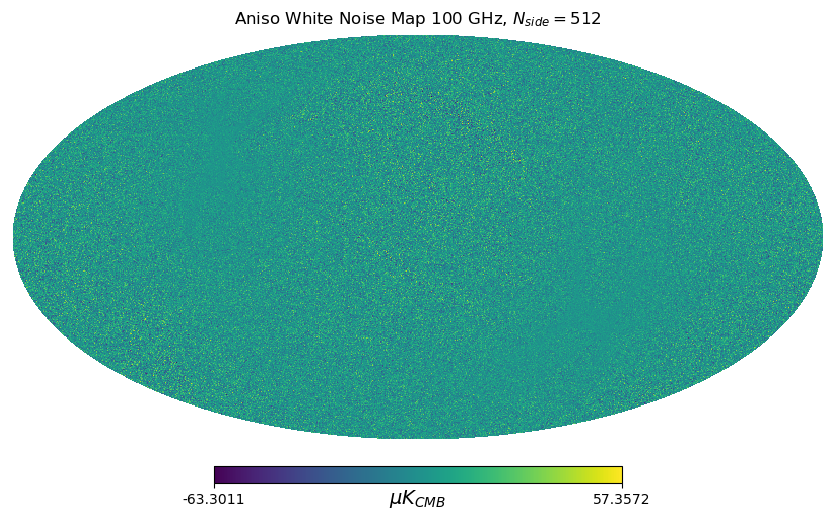

In [16]:
hp.mollview(wht_map, unit="$\\mu K_{CMB}$",
            title="Aniso White Noise Map" + f" {DETECTOR} GHz, " + "$N_{side}" + f"={NSIDE_512}$")

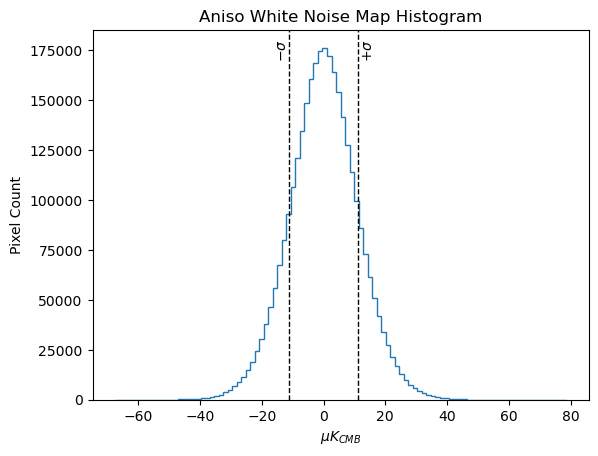

In [17]:
make_map_hist(wht_map, f100_noise_px_512_uK, title="Aniso White Noise Map Histogram")

In [18]:
assert hp.npix2nside(wht_map.shape[0]) == NSIDE_512
print(f"We confirm that the map is resolution {hp.npix2nside(wht_map.shape[0])}")

We confirm that the map is resolution 512


In [19]:
lmax_512 = get_lmax_for_nside(NSIDE_512)
ells_512 = np.arange(lmax_512 + 1)
wht_cl = hp.anafast(wht_map, lmax=lmax_512)

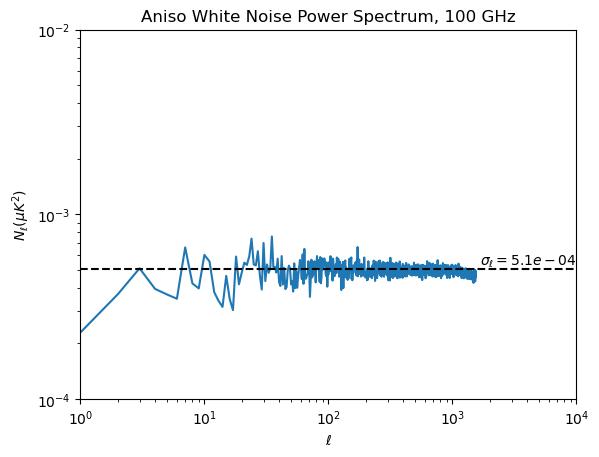

In [20]:
# Add the white noise level line to the plot; see if it matches expectations
plot_ps(wht_cl,
        title=f"Aniso White Noise Power Spectrum, {DETECTOR} GHz",
        white_noise_expected=f100_noise_ps_uK2)

The white noise lines up with published values (from Planck 2018 I, Table 4).

# Getting Power Spectrum of Sim Noise

Method (from Appendix A of Planck CO Revisited, Ghosh, S., et al.: A&A, 688, A54):
- Get simulation (Sim) with correct anisotropy (not listed as a step in Appendix A)
- Step 4: Compute Cl^TT of Sim (SCl)

- Step 1: Generate white noise temperature map (WhT) as above
- Step 2: Convert WhT to alm space (WAS)
- Step 3: Compute Cl^TT of WAS (WCl)
- Step 5: Multiply WAS by SCl^{1/2} * WCl^{-1/2} (element-wise, since these are vectors?)
    - Tried with and without boxcar filter

In [21]:
# Step 0
src_map_fn = get_planck_noise_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY, realization=PLANCK_SIM_NUM)
src_map = hp.read_map(src_map_fn) * 1e6

File /data/jim/CMB_Data/Assets/Planck/ffp10_noise_100_full_map_mc_00000.fits exists.


N_side: 2048


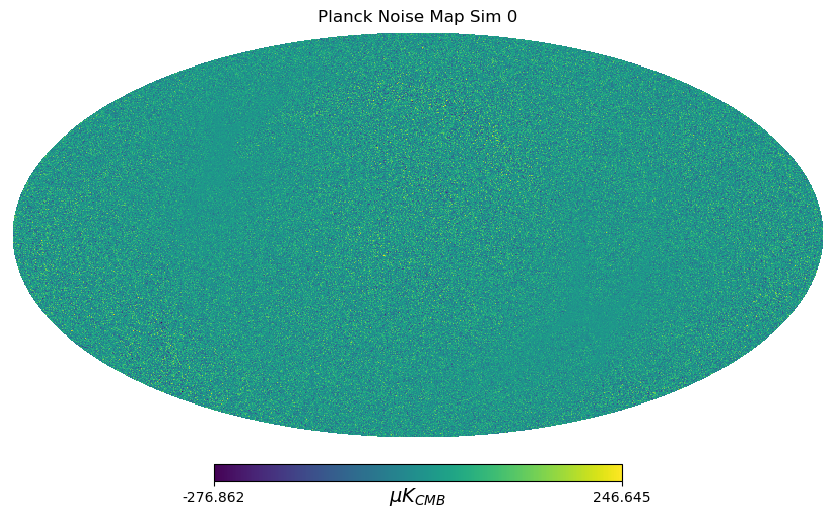

In [22]:
# Plot the loaded map, to ensure there's nothing goofy going on
hp.mollview(src_map, unit="$\\mu K_{CMB}$", title=f"Planck Noise Map Sim {PLANCK_SIM_NUM}")
print(f"N_side: {hp.get_nside(src_map)}")

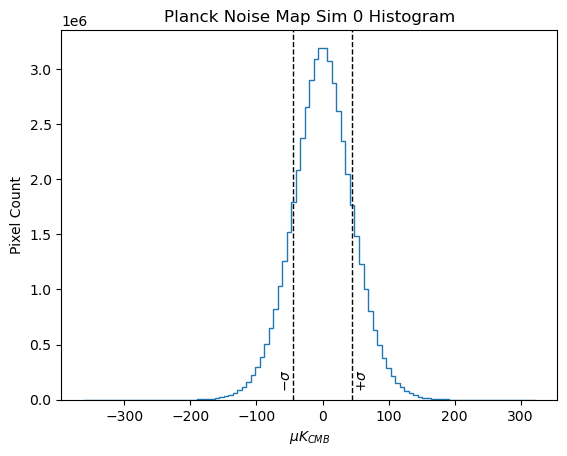

In [23]:
make_map_hist(src_map, f100_noise_px_2048_uK, title=f"Planck Noise Map Sim {PLANCK_SIM_NUM} Histogram")

In [24]:
# Step 4: Get PS of simulated map, (to be done once for all simulations)

# This is equivalent to the following; it just uses more resources. Don't do it.
# lmax_2048 = get_lmax_for_nside(NSIDE_2048)
# src_alm = hp.map2alm(src_map, lmax=lmax_2048)
# src_cl_full = hp.alm2cl(src_alm)  # retained for curiosity only
# src_cl = src_cl_full[:lmax_512+1]
# del src_alm

# This is the correct way to do it
src_cl = hp.anafast(src_map, lmax=lmax_512)

In [25]:
# Step 1: Get white noise map - Done above in previous section
#         (Cell is deliberately empty)

In [26]:
# Step 2: Get white noise map in alm domain
wht_alm = hp.map2alm(wht_map, lmax=lmax_512)

In [27]:
# Step 3: Get PS of smoothed white noise map
wht_cl = hp.alm2cl(wht_alm, lmax=lmax_512, lmax_out=lmax_512)

In [28]:
# Step 5: Create filter, mulitply alms by filter
def make_filter(boxcar_length, target_cl, source_cl, smooth_initial=True):
    temp_source_cl = source_cl.copy()
    if boxcar_length == 1:
        return np.sqrt(target_cl / source_cl)
    if smooth_initial:
        # Noise is white and should be ~constant.
        #    Sometimes the white noise may have very low values in the first few ell bins.
        #    This can cause the filter to be very large in those bins, causing spurious low-ell power.
        #    I'm not sure if it would be better to average these (biased low) or add them (biased high); 
        #    either way these are generally log-scale and we get more reasonable values.
        # source_cl[0] = np.mean(source_cl[0], source_cl.mean())
        # source_cl[1] = np.mean(source_cl[1], source_cl.mean())
        temp_source_cl[0] = source_cl[0] + source_cl.mean()
        temp_source_cl[1] = source_cl[1] + source_cl.mean()
    f = np.sqrt(target_cl / temp_source_cl)
    boxcar = np.ones(boxcar_length)
    f = np.pad(f, (boxcar_length // 2, boxcar_length // 2), mode='edge')
    f = np.convolve(f, boxcar, mode='same') / np.sum(boxcar)
    return f

In [29]:
my_filter = make_filter(BOXCAR_LENGTH, src_cl, wht_cl, smooth_initial=SMOOTH_INITIAL)
out_alm = hp.almxfl(wht_alm, my_filter)

In [30]:
out_map = hp.alm2map(out_alm, nside=NSIDE_512, lmax=lmax_512)

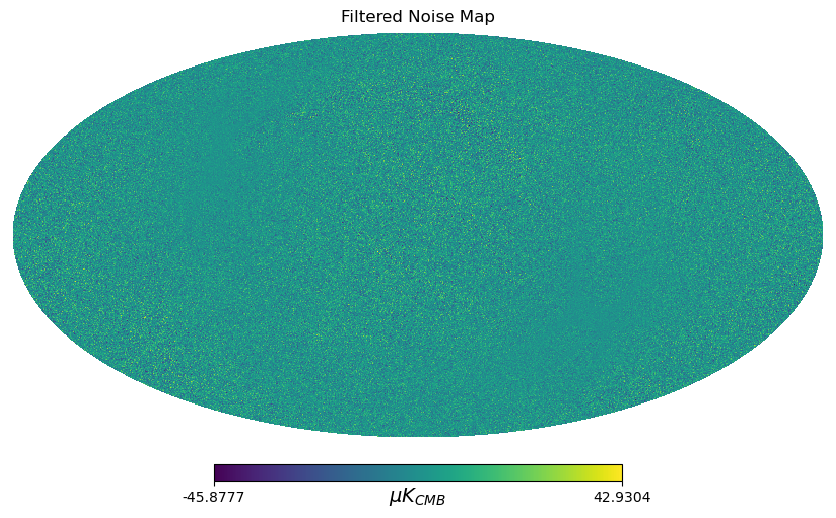

In [31]:
hp.mollview(out_map, unit="$\\mu K_{CMB}$", title="Filtered Noise Map")

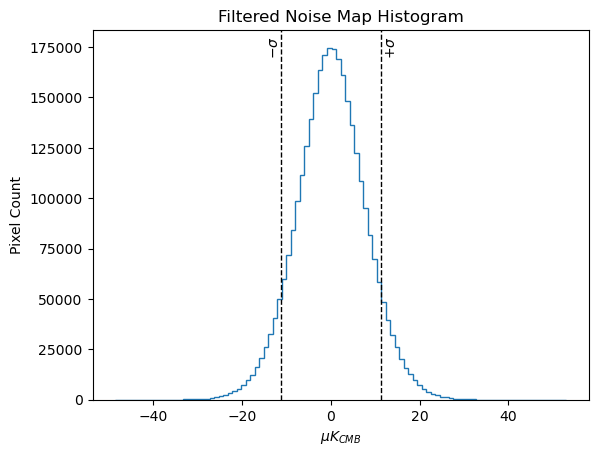

In [32]:
make_map_hist(out_map, f100_noise_px_512_uK, title="Filtered Noise Map Histogram")

In [33]:
out_map2ps = hp.anafast(out_map, lmax=lmax_512)

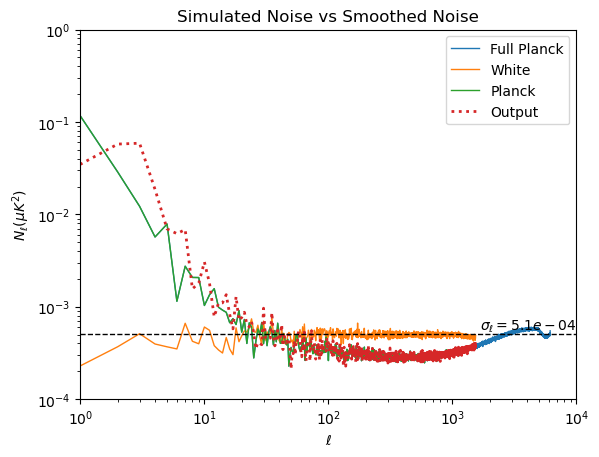

In [35]:
lmax_2048 = get_lmax_for_nside(NSIDE_2048)
src_cl_full = hp.anafast(src_map, lmax=lmax_2048)

plot_many_ps([
              src_cl_full,
              wht_cl, 
              src_cl, 
              out_map2ps,
              ], 
              labels=[
                  "Full Planck",
                  "White", 
                  "Planck", 
                  "Output",
                  ],
              y_high=1,
            #   y_low=1e-10,
              styles=[
                      "-",
                      "-",
                      "-", 
                      ":"],
                    #  ],
              title="Simulated Noise vs Smoothed Noise",
              white_noise_expected=f100_noise_ps_uK2)